In [26]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [41]:
directory = 'data/Respiratory_Sound_Database/clips_by_cycle'
dataset = []
diseases = []
sounds = [] # 0 crackle, 1 wheeze, 2 both, 3 neither
df = pd.read_csv('data/data_complete.csv')
        
sample_rate = 4000
mfcc_size = 13

for file in os.listdir(directory):
    
    if file.endswith('.wav'):
        file_path = os.path.join(directory, file)

        data, _ = librosa.load(file_path)

        trimmed_data, _ = librosa.effects.trim(y=data)

        mfccs = librosa.feature.mfcc(y=trimmed_data, 
                                        sr=sample_rate, 
                                        n_mfcc=mfcc_size)

        stddev_mfccs = np.std(mfccs, axis=1)

        mean_mfccs = np.mean(mfccs, axis=1)

        average_difference = np.zeros((mfcc_size,))
        for i in range(0, len(mfccs.T) - 2, 2):
            average_difference += mfccs.T[i] - mfccs.T[i+1]
        average_difference /= (len(mfccs) // 2)   
        average_difference = np.array(average_difference)

        concat_features = np.hstack((stddev_mfccs, mean_mfccs))
        concat_features = np.hstack((concat_features, average_difference))
        
        dataset += [(file, concat_features)]

data/Respiratory_Sound_Database/clips_by_cycle/215_1b3_Tc_sc_Meditron_cycle6.wav
0


In [17]:
all_file_paths, mfcc_features = zip(*dataset)
    
mfcc_features = np.array(mfcc_features)

mfcc_tuples = []

all_json = dict()
all_json["filenames"] = all_file_paths

print(len(all_file_paths), 
      mfcc_features.shape)

6898 (6898, 39)


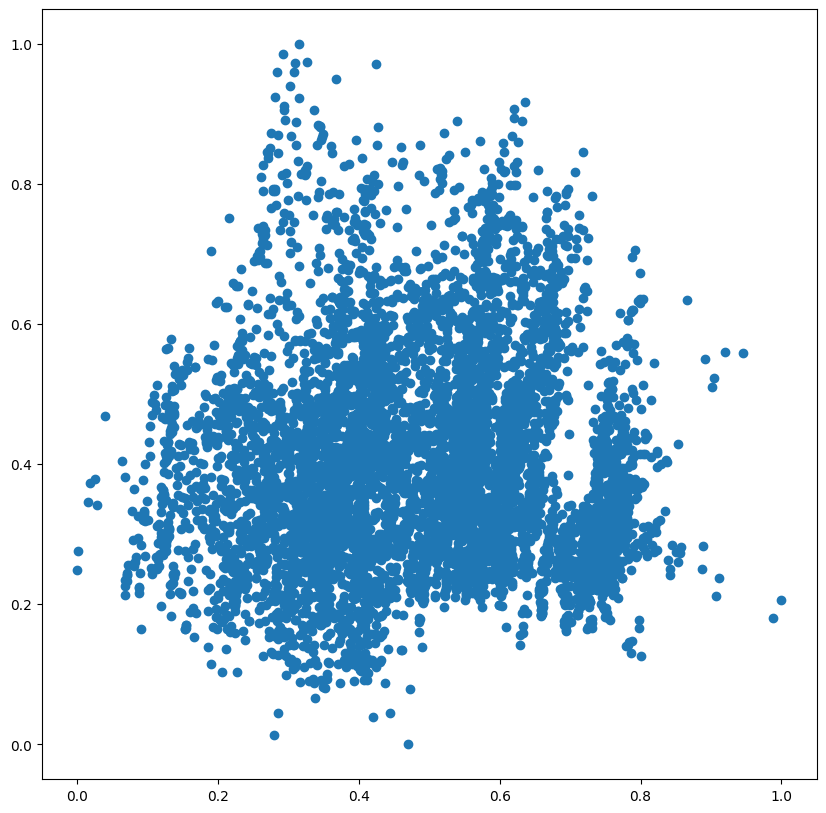

In [21]:
def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data

def get_pca(features):
    pca = PCA(n_components=2)
    transformed = pca.fit(features).transform(features)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed)

pca_mfcc = get_pca(mfcc_features)

mfcc_key = 'pcamfcc'

all_json[mfcc_key] = transform_numpy_to_json(pca_mfcc)
plt.figure(figsize=(10, 10))
_ = plt.scatter(pca_mfcc.T[0],
                pca_mfcc.T[1])
plt.show()